In [113]:
# for Q-Q plots
import scipy.stats as stats

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import scipy.stats as stats
from feature_engine import variable_transformers as vt
from sklearn.preprocessing import StandardScaler
from feature_engine.outlier_removers import Winsorizer
import warnings
warnings.filterwarnings("ignore") 

In [114]:
train_data = pd.read_csv("train.csv")

In [115]:
# transform type

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)

In [116]:
# separate object and numerical columns. Separate area and surface area columns and year columns as wel

cat_cols = [x for x in train_data.columns if train_data[x].dtype==np.object]
num_cols = [x for x in train_data.columns if train_data[x].dtype!=np.object]
area_cols = [x for x in train_data.columns if ("SF" in x)|("Area" in x)|(x=="LotFrontage")]
year_cols = [x for x in num_cols if 'Yr' in x or 'Year' in x]

In [117]:
# split train and test

X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['Id', 'SalePrice'], axis=1),
                                                    train_data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape


((1314, 79), (146, 79))

In [118]:
# function to calculate elapsed time

def elapsed_years(df, cols):
    # capture difference between year col and
    # year the house was sold
    for col in cols:
        if col=='YrSold':
            continue
        df[col] = df['YrSold'] - df[col]
   
    return df

X_train = elapsed_years(X_train, year_cols)
X_test = elapsed_years(X_test, year_cols)

In [119]:
# lets drop YrSold and MiscVal

X_train.drop(['YrSold', 'MiscVal'], axis=1, inplace=True)
X_test.drop(['YrSold', 'MiscVal'], axis=1, inplace=True)

In [120]:
# function to create histogram, Q-Q plot and
# boxplot for a column

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title(variable+' Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(variable+' Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(variable+' Boxplot')

    plt.show()

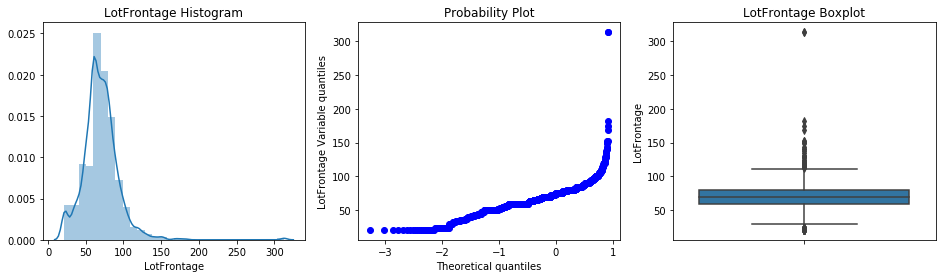

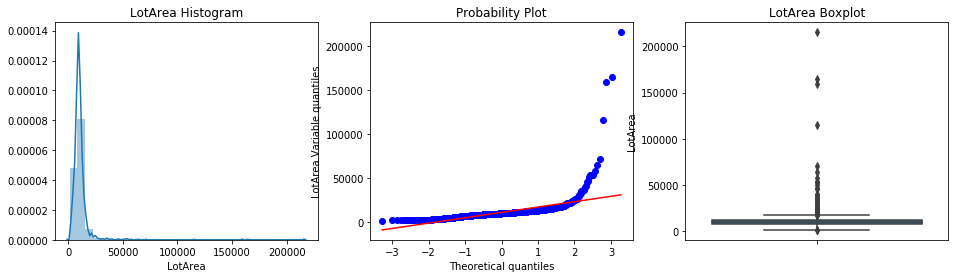

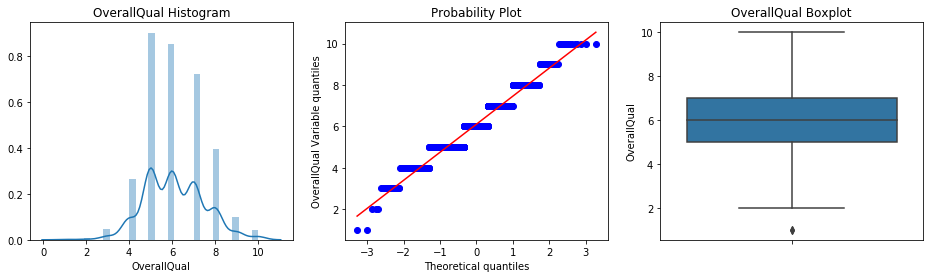

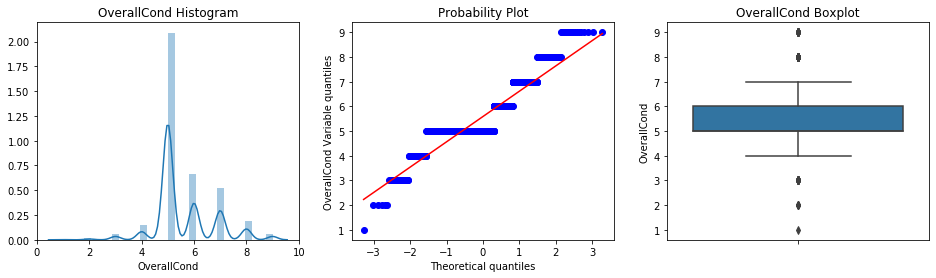

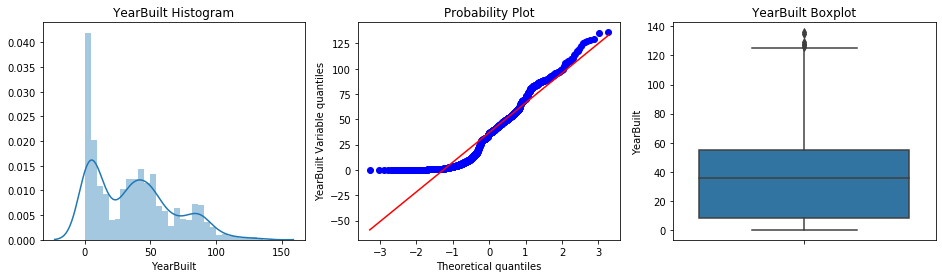

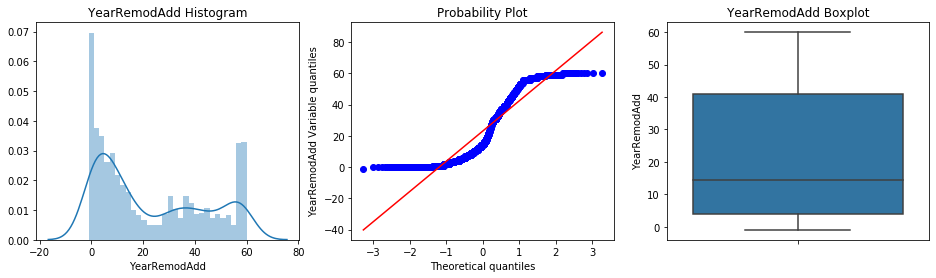

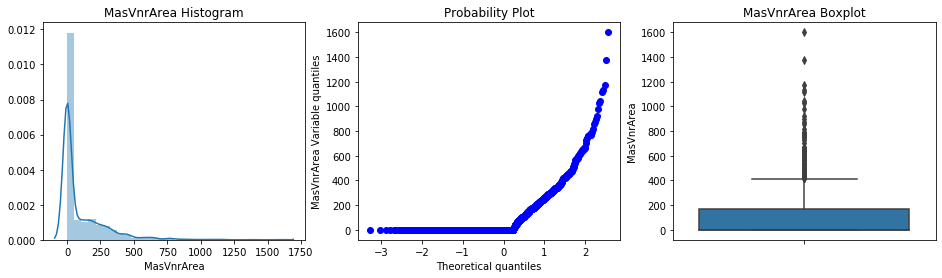

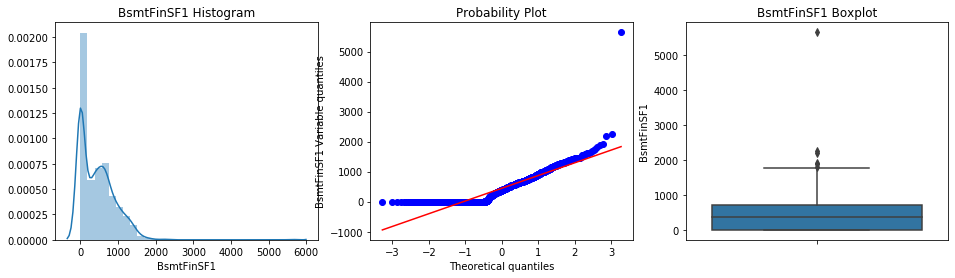

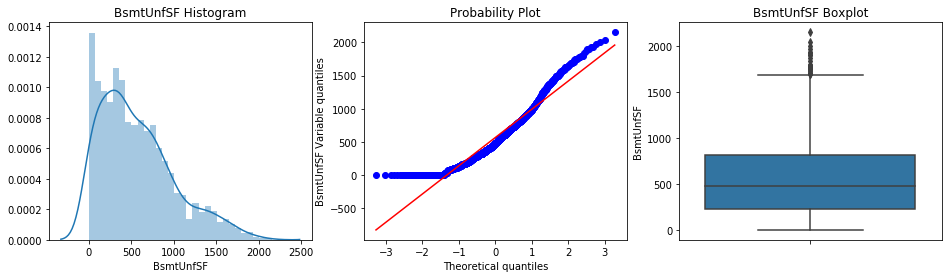

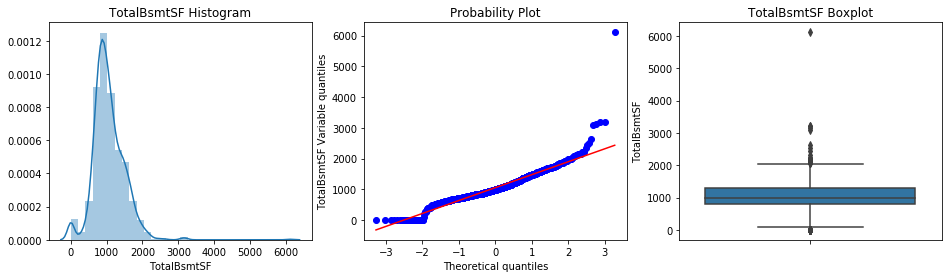

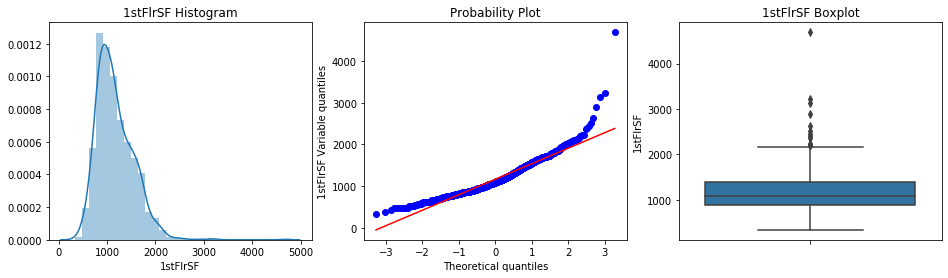

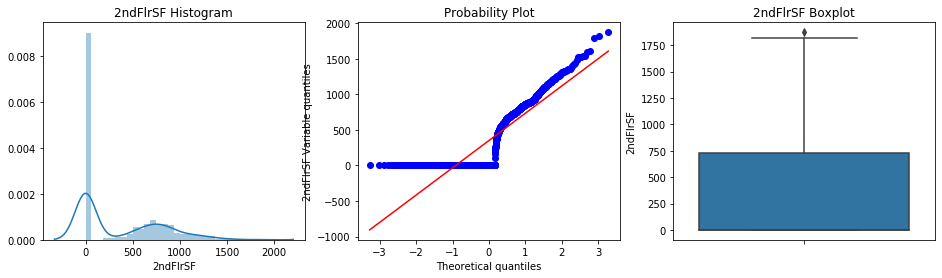

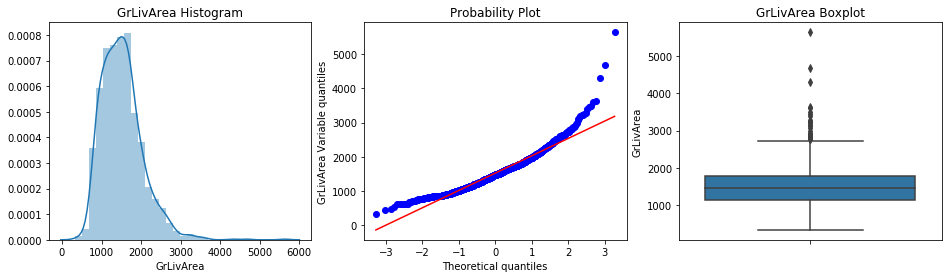

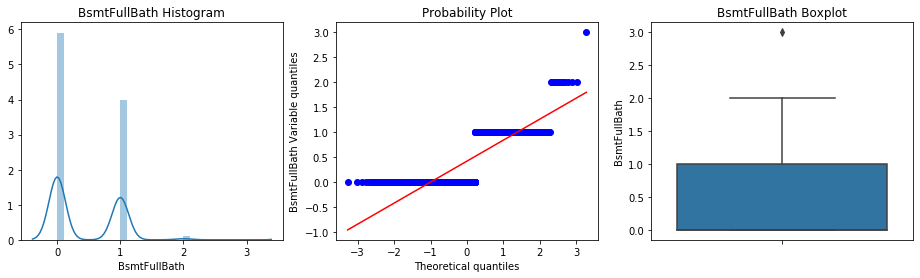

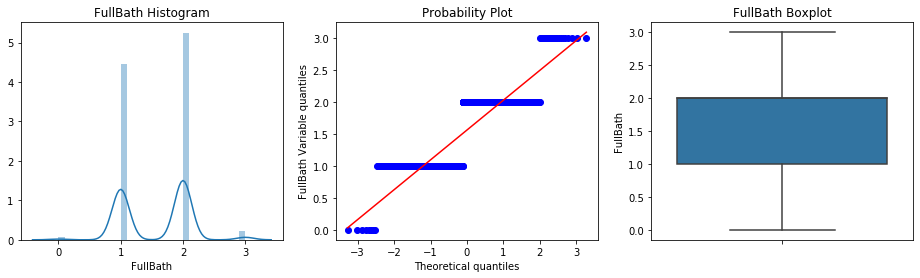

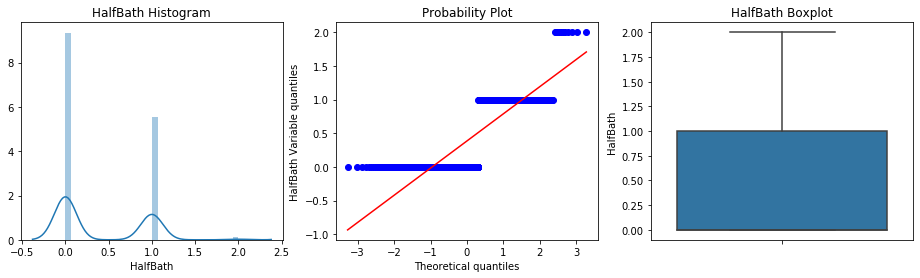

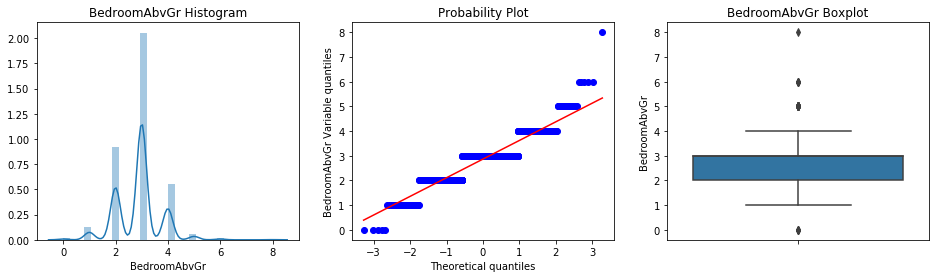

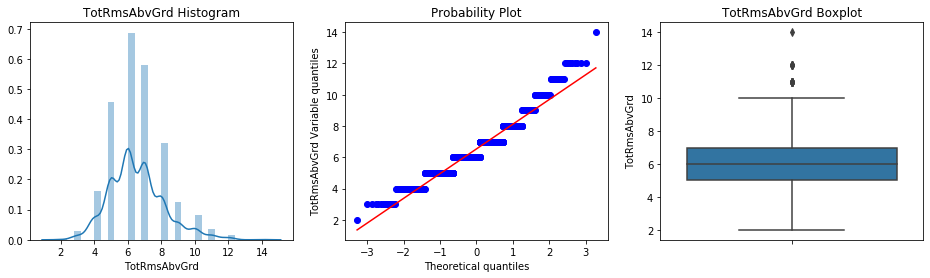

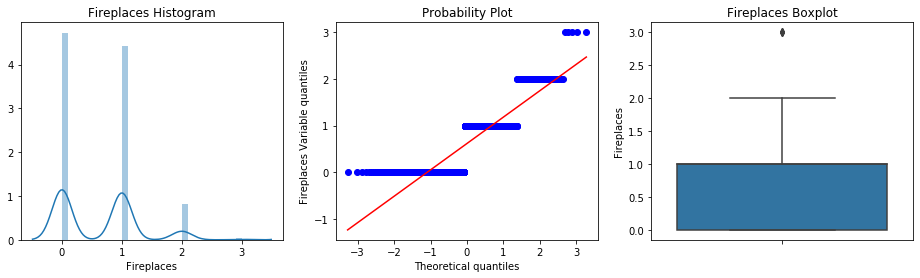

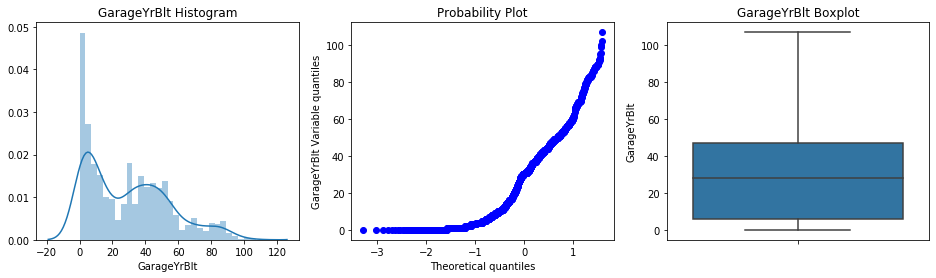

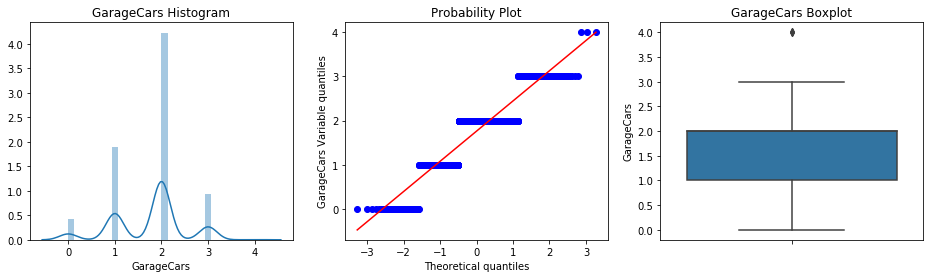

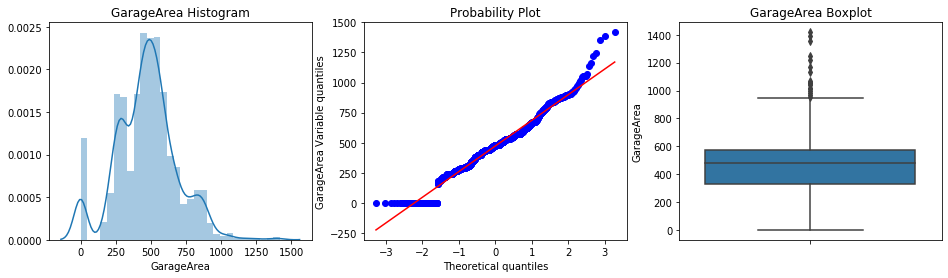

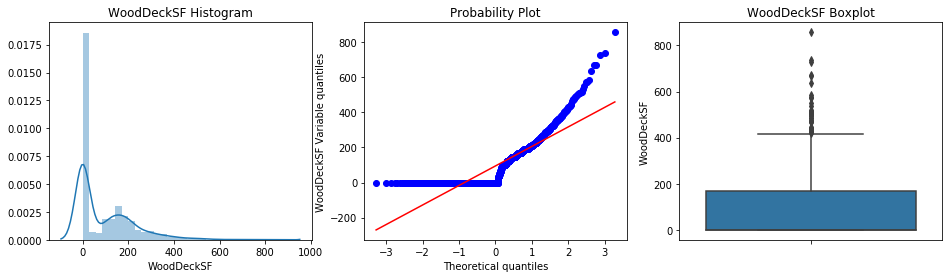

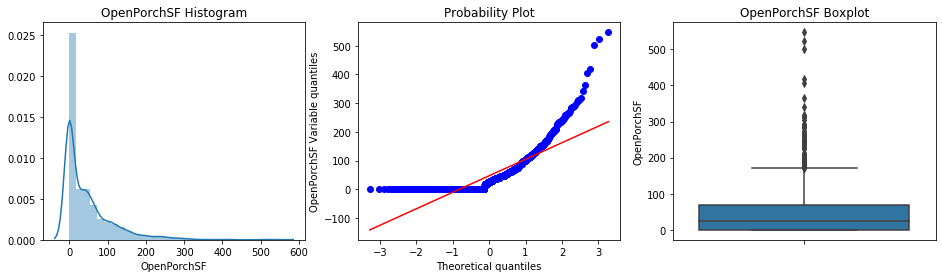

In [121]:

for col in num_cols:
    if col in ['Id', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch',
               'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']:
        continue
    diagnostic_plots(X_train, col)

In [122]:
num_cols

['Id',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'SalePrice']

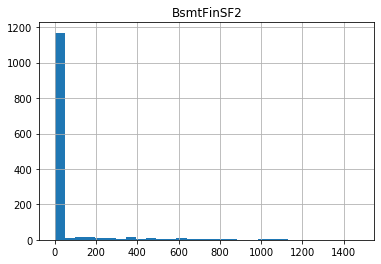

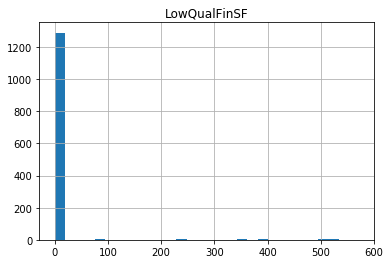

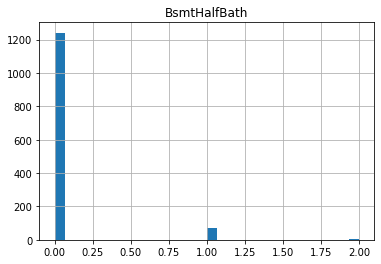

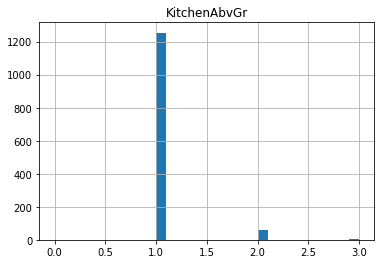

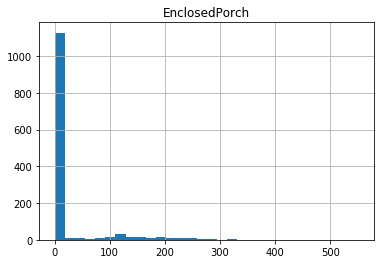

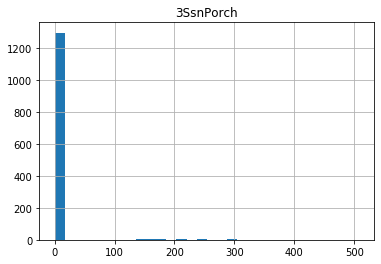

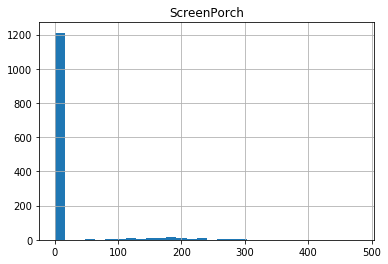

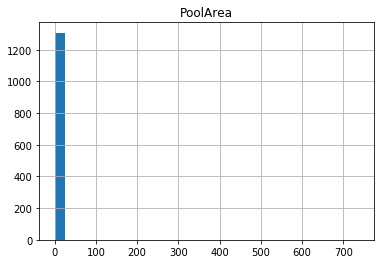

In [123]:
# these list of cols have almost constant values

almost_const_cols = ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch',
               'ScreenPorch', 'PoolArea']

for col in almost_const_cols:
    X_train[col].hist(bins=30)
    plt.title(col)
    plt.show()

In [124]:
# for some of these almost constant columns, it makes sense to engineer another binary feature. Example: if pool area is 
# greater than 0, then 1 (there is a pool), otherwise it is zero. 

to_binary_cols = ['BsmtFinSF2', 'LowQualFinSF',  'EnclosedPorch', '3SsnPorch',
               'ScreenPorch', 'PoolArea', 'BsmtHalfBath']
def convert_to_binary(df, col_list, thresh=0):
    for col in col_list:
        df.loc[df[col] > thresh, col] = 1
        df.loc[df[col] <= thresh, col] = 0
    return df

X_train = convert_to_binary(X_train, to_binary_cols)
X_test = convert_to_binary(X_test, to_binary_cols)

In [125]:
# cap extreme outliers outside 3*IQR. Only right tail. Apply on area cols that where not binarized

cap_out_cols = list(set(area_cols)-set(to_binary_cols))
print(cap_out_cols)
windsoriser = Winsorizer(distribution='skewed', # choose skewed for IQR rule boundaries or gaussian for mean and std
                          tail='right', # cap left, right or both tails 
                          fold=3,
                          variables=cap_out_cols)

windsoriser.fit(X_train)


['TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'GarageArea', 'OpenPorchSF', 'GrLivArea', 'BsmtUnfSF', 'LotArea', 'LotFrontage']


Winsorizer(distribution='skewed', fold=3, tail='right',
           variables=['TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', '2ndFlrSF',
                      'MasVnrArea', 'WoodDeckSF', 'GarageArea', 'OpenPorchSF',
                      'GrLivArea', 'BsmtUnfSF', 'LotArea', 'LotFrontage'])

In [126]:
X_train_trim = windsoriser.transform(X_train)

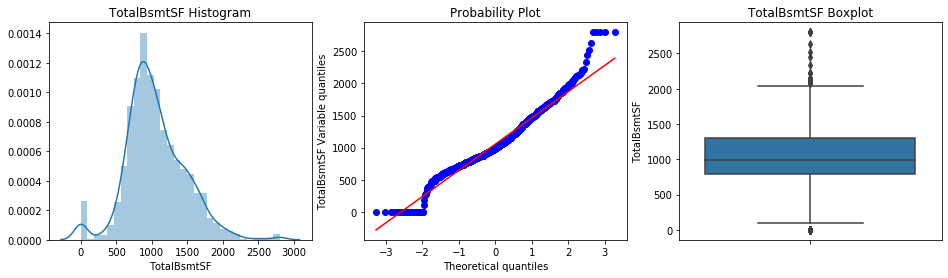

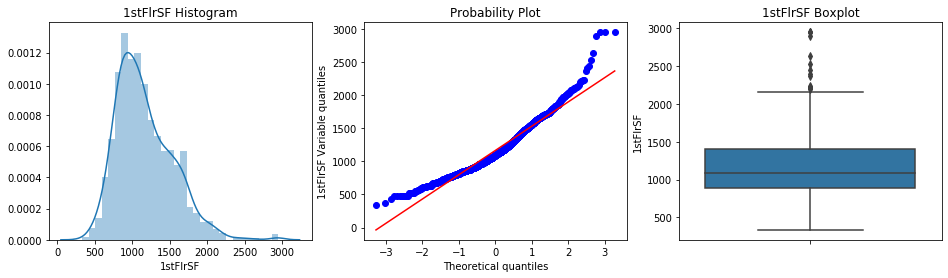

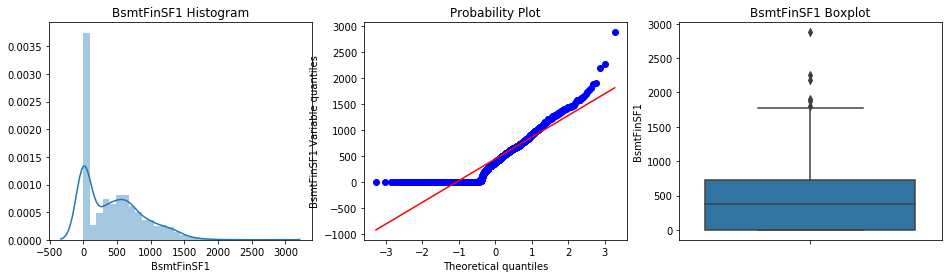

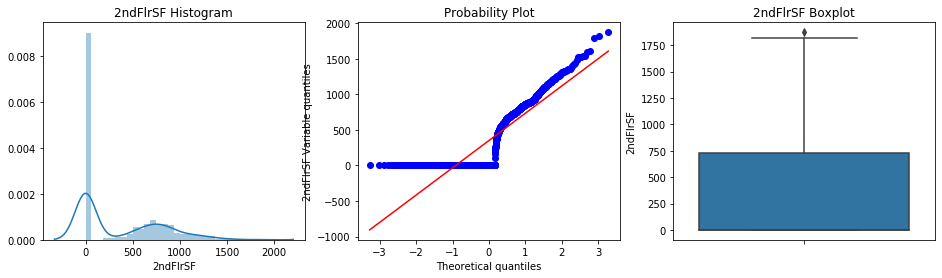

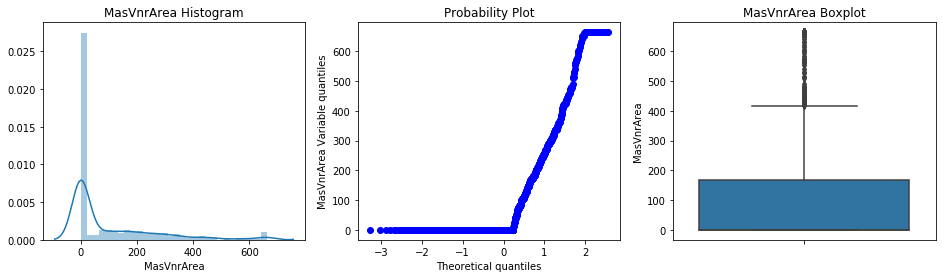

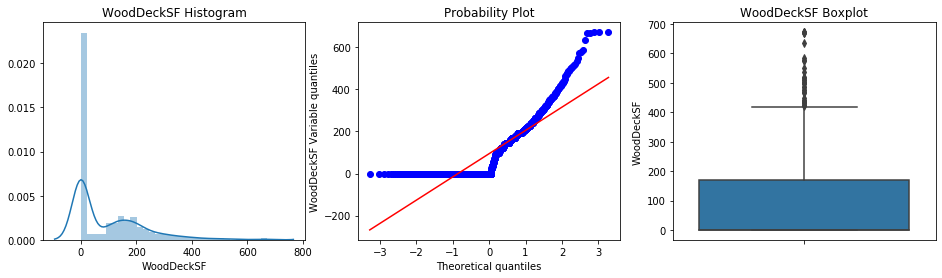

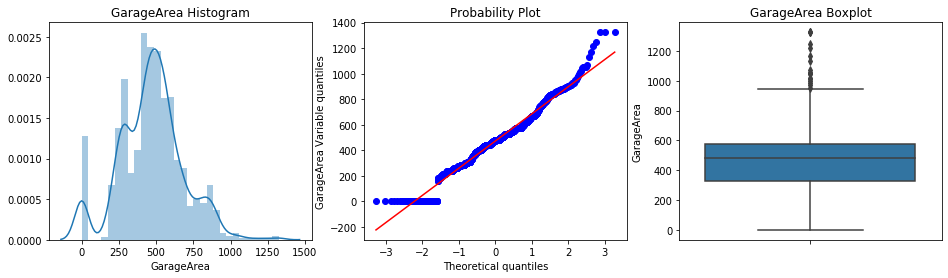

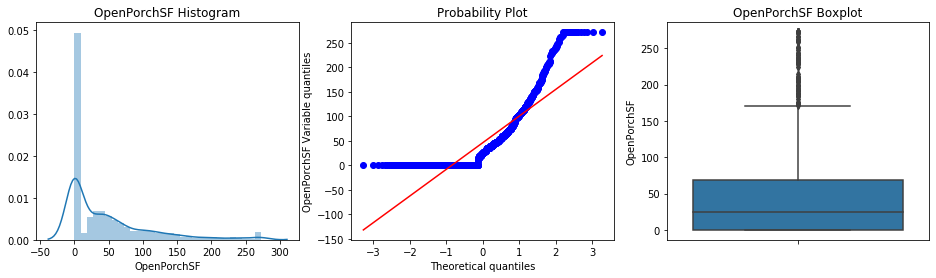

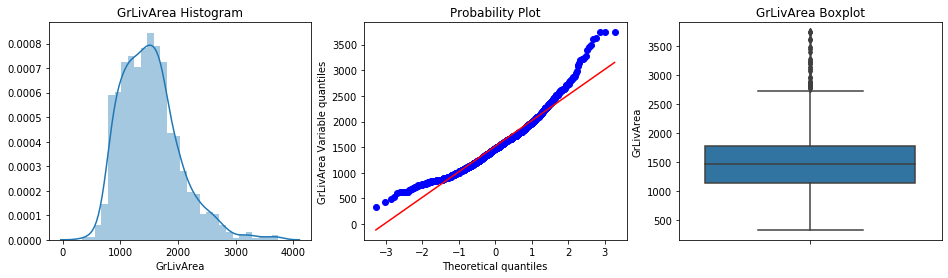

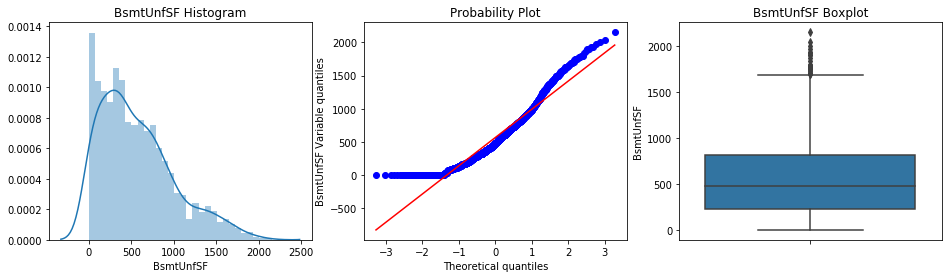

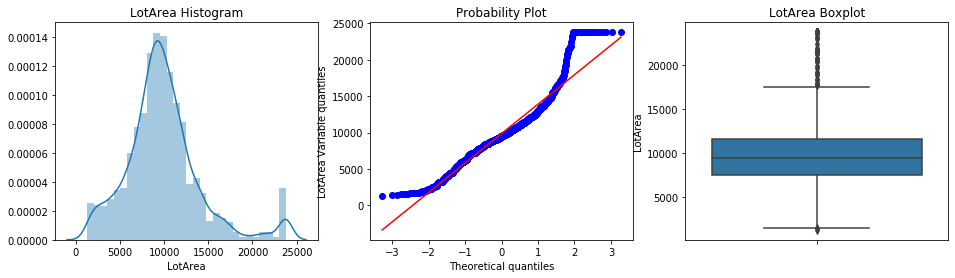

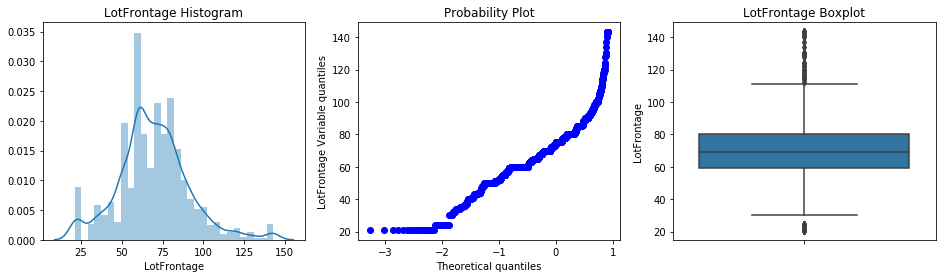

In [127]:
for col in cap_out_cols:
    diagnostic_plots(X_train_trim, col)

In [128]:
# impute numerical cols with median value

# define an imputation function
def impute_na_median(df, cols):
    for col in cols:
        df[col]= df[col].fillna(df[col].median())
    
    return df

# apply on train set and test set
X_train_trim_imp = impute_na_median(X_train_trim, cols=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])
X_test_imp = impute_na_median(X_test, cols=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])

In [129]:
# impute cat cols with a 'NA' label

# define an imputation function
def impute_na_label(df, cols):
    for col in cols:
        df[col]= df[col].fillna('NA')
    
    return df

# apply on train set and test set
X_train_trim_imp = impute_na_label(X_train_trim_imp, cols=cat_cols)
X_test_imp = impute_na_label(X_test_imp, cols=cat_cols)

In [130]:
for col in X_train_trim_imp.columns:
    if X_train_trim_imp[col].isnull().sum() > 0:
        print(col, X_train_trim_imp[col].isnull().mean())

In [131]:
# transform the capped area columns to enhance skew

yjt = vt.YeoJohnsonTransformer(variables = cap_out_cols)
yjt.fit(X_train_trim_imp)
print(yjt.lambda_dict_)
X_train_trim_imp_tr = yjt.transform(X_train_trim_imp)
X_test_imp_tr = yjt.transform(X_test_imp)

{'TotalBsmtSF': 0.8003281161845143, '1stFlrSF': 0.007899326311500723, 'BsmtFinSF1': 0.22563422365693778, '2ndFlrSF': -0.12038141633304861, 'MasVnrArea': -0.2534184801587352, 'WoodDeckSF': -0.08540334285392102, 'GarageArea': 0.8103785843826001, 'OpenPorchSF': 0.019829141780980476, 'GrLivArea': 0.09383380176194477, 'BsmtUnfSF': 0.4741451871581765, 'LotArea': 0.5315733758668301, 'LotFrontage': 0.7561503532414434}


In [132]:
# Apply rare label encoding on some of the cat cols

rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=cat_cols # apply to all categorical columns
) 

rare_encoder.fit(X_train_trim_imp_tr)
X_train_trim_imp_tr_enc = rare_encoder.transform(X_train_trim_imp_tr)
X_test_imp_tr_enc = rare_encoder.transform(X_test_imp_tr)

In [133]:
rare_encoder.encoder_dict_

{'MSSubClass': Index(['20', '60', '50', '120'], dtype='object'),
 'MSZoning': Index(['RL', 'RM'], dtype='object'),
 'Street': array(['Pave', 'Grvl'], dtype=object),
 'Alley': array(['NA', 'Grvl', 'Pave'], dtype=object),
 'LotShape': array(['IR1', 'Reg', 'IR3', 'IR2'], dtype=object),
 'LandContour': array(['HLS', 'Lvl', 'Low', 'Bnk'], dtype=object),
 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object),
 'LotConfig': Index(['Inside', 'Corner', 'CulDSac'], dtype='object'),
 'LandSlope': array(['Gtl', 'Mod', 'Sev'], dtype=object),
 'Neighborhood': Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
        'Gilbert', 'Sawyer'],
       dtype='object'),
 'Condition1': Index(['Norm', 'Feedr'], dtype='object'),
 'Condition2': Index(['Norm'], dtype='object'),
 'BldgType': Index(['1Fam', 'TwnhsE'], dtype='object'),
 'HouseStyle': Index(['1Story', '2Story', '1.5Fin'], dtype='object'),
 'RoofStyle': Index(['Gable', 'Hip'], dtype='object'),
 'RoofMatl': Index(['CompShg'], dtyp

In [134]:
# Apply hot one encoding next

ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    drop_last=False) # automatically detects all cat vars in data

ohe_enc.fit(X_train_trim_imp_tr_enc)

X_train_trim_imp_tr_enc = ohe_enc.transform(X_train_trim_imp_tr_enc)
X_test_imp_tr_enc = ohe_enc.transform(X_test_imp_tr_enc)

In [135]:
# scaling the features 

scaler = StandardScaler()
scaler.fit(X_train_trim_imp_tr_enc)

# transform 
X_train_trim_imp_tr_enc_sc = scaler.transform(X_train_trim_imp_tr_enc)
X_test_imp_tr_enc_sc = scaler.transform(X_test_imp_tr_enc)

In [136]:
lightgbm_regr = LGBMRegressor()

lightgbm_regr.fit(X_train_trim_imp_tr_enc_sc, y_train)

y_pred_train = lightgbm_regr.predict(X_train_trim_imp_tr_enc_sc)
y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)
print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
print()
print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
print('test r2: {}'.format(r2_score(y_test, y_pred_test)))

train mse: 124454239.62391268
train rmse: 11155.906042268045
train r2: 0.9800676504294124
train rmsle: 0.05488385997916426

test mse: 1106329872.47313
test rmse: 33261.53743399619
test rmsle: 0.1242579564595499
test r2: 0.839011741461563


In [138]:
lambdas=[1e-3, 1e-2, 0.1, 1.0, 10, 20]

for lambda_value in lambdas:
    lightgbm_regr = LGBMRegressor(lambda_l1=lambda_value)    
    lightgbm_regr.fit(X_train_trim_imp_tr_enc_sc, y_train)

    y_pred_train = lightgbm_regr.predict(X_train_trim_imp_tr_enc_sc)
    y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)
   
    print("For lambda = {}".format(lambda_value))
    #print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
    #print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    #print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
    print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
    #print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
    #print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
    #print('test r2: {}'.format(r2_score(y_test, y_pred_test)))
    print()

For lambda = 0.001
train rmsle: 0.054883860154889344
test rmsle: 0.12425795642901966

For lambda = 0.01
train rmsle: 0.054883861740773074
test rmsle: 0.12425795611598399

For lambda = 0.1
train rmsle: 0.05499721718070765
test rmsle: 0.12441890376743364

For lambda = 1.0
train rmsle: 0.054826907937596384
test rmsle: 0.1244502149801749

For lambda = 10
train rmsle: 0.0550422104026366
test rmsle: 0.12162186666604329

For lambda = 20
train rmsle: 0.05572457223503501
test rmsle: 0.1237431239066696



In [140]:
# lambda1 = 1.0 is the best value. we can also tune other params for the model for additional regularization

feature_fractions = list(np.arange(0.1,1.1,step=0.10))

for frac in feature_fractions:
    lightgbm_regr = LGBMRegressor(lambda_l1=1.0, feature_fraction=frac)    
    lightgbm_regr.fit(X_train_trim_imp_tr_enc_sc, y_train)

    y_pred_train = lightgbm_regr.predict(X_train_trim_imp_tr_enc_sc)
    y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)
   
    print("For feature_fraction = {}".format(frac))
    #print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
    #print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    #print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
    print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
    #print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
    #print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
    #print('test r2: {}'.format(r2_score(y_test, y_pred_test)))
    print()


For feature_fraction = 0.1
train rmsle: 0.07861863277837011
test rmsle: 0.12959791468555043

For feature_fraction = 0.2
train rmsle: 0.06471854256171149
test rmsle: 0.1164166883426228

For feature_fraction = 0.30000000000000004
train rmsle: 0.06101676706158936
test rmsle: 0.12105082987873479

For feature_fraction = 0.4
train rmsle: 0.059197898916747135
test rmsle: 0.12171069133659294

For feature_fraction = 0.5
train rmsle: 0.05768743931734413
test rmsle: 0.1245487525497286

For feature_fraction = 0.6
train rmsle: 0.05526205249542009
test rmsle: 0.12353721463708216

For feature_fraction = 0.7000000000000001
train rmsle: 0.05716155097750906
test rmsle: 0.12222111811858155

For feature_fraction = 0.8
train rmsle: 0.055251406255676136
test rmsle: 0.12535832046859627

For feature_fraction = 0.9
train rmsle: 0.05540236526892778
test rmsle: 0.1291949280426712

For feature_fraction = 1.0
train rmsle: 0.054826907937596384
test rmsle: 0.1244502149801749



In [142]:
number_leaves = list(np.arange(2,31,step=2))+[31]

for num in number_leaves:
    lightgbm_regr = LGBMRegressor(lambda_l1=1.0, feature_fraction=0.20, num_leaves=num)    
    lightgbm_regr.fit(X_train_trim_imp_tr_enc_sc, y_train)

    y_pred_train = lightgbm_regr.predict(X_train_trim_imp_tr_enc_sc)
    y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)
   
    print("For num_leaves = {}".format(num))
    #print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
    #print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    #print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
    print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
    #print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
    #print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
    #print('test r2: {}'.format(r2_score(y_test, y_pred_test)))
    print()


For num_leaves = 2
train rmsle: 0.15458407123543422
test rmsle: 0.14509060289132955

For num_leaves = 4
train rmsle: 0.12476019476911157
test rmsle: 0.1314704879472034

For num_leaves = 6
train rmsle: 0.11125268028174147
test rmsle: 0.12494519649615701

For num_leaves = 8
train rmsle: 0.10381778101059931
test rmsle: 0.11937029686760875

For num_leaves = 10
train rmsle: 0.09754164275649799
test rmsle: 0.12021653786810564

For num_leaves = 12
train rmsle: 0.09302733709728153
test rmsle: 0.11997841091672398

For num_leaves = 14
train rmsle: 0.08781338597865758
test rmsle: 0.1216423727535332

For num_leaves = 16
train rmsle: 0.08335529993910938
test rmsle: 0.11571054936614524

For num_leaves = 18
train rmsle: 0.08063906182306958
test rmsle: 0.11641295479267995

For num_leaves = 20
train rmsle: 0.07691662373503294
test rmsle: 0.11968588413954846

For num_leaves = 22
train rmsle: 0.07465639219951674
test rmsle: 0.11917511295602702

For num_leaves = 24
train rmsle: 0.07254650929800299
test rm

In [143]:
bagging_fractions = list(np.arange(0.1,1.1,step=0.10))

for frac in bagging_fractions:
    lightgbm_regr = LGBMRegressor(lambda_l1=1.0, feature_fraction=0.20, num_leaves=26, bagging_fraction=frac, 
                                 bagging_freq=5)    
    lightgbm_regr.fit(X_train_trim_imp_tr_enc_sc, y_train)

    y_pred_train = lightgbm_regr.predict(X_train_trim_imp_tr_enc_sc)
    y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)
   
    print("For bagging_fraction = {}".format(frac))
    #print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
    #print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    #print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
    print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
    #print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
    #print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
    #print('test r2: {}'.format(r2_score(y_test, y_pred_test)))
    print()


For bagging_fraction = 0.1
train rmsle: 0.16068888304441006
test rmsle: 0.1593299343679357

For bagging_fraction = 0.2
train rmsle: 0.12817971608939588
test rmsle: 0.14152632315099783

For bagging_fraction = 0.30000000000000004
train rmsle: 0.1116034907818785
test rmsle: 0.12946868290206698

For bagging_fraction = 0.4
train rmsle: 0.09985838820627954
test rmsle: 0.11909064132630931

For bagging_fraction = 0.5
train rmsle: 0.09052480187745891
test rmsle: 0.12526969256701742

For bagging_fraction = 0.6
train rmsle: 0.0844437838391017
test rmsle: 0.12035298501366316

For bagging_fraction = 0.7000000000000001
train rmsle: 0.0795210840664608
test rmsle: 0.11969776262632321

For bagging_fraction = 0.8
train rmsle: 0.07479587657693139
test rmsle: 0.12315759636078737

For bagging_fraction = 0.9
train rmsle: 0.07301547843689532
test rmsle: 0.11860951426831912

For bagging_fraction = 1.0
train rmsle: 0.07048250339394681
test rmsle: 0.11488492725661213



In [145]:
max_depths = list(np.arange(3,15,step=2))+[-1]

for depth in max_depths:
    lightgbm_regr = LGBMRegressor(lambda_l1=1.0, feature_fraction=0.20, num_leaves=26, max_depth=depth)    
    lightgbm_regr.fit(X_train_trim_imp_tr_enc_sc, y_train)

    y_pred_train = lightgbm_regr.predict(X_train_trim_imp_tr_enc_sc)
    y_pred_test = lightgbm_regr.predict(X_test_imp_tr_enc_sc)
   
    print("For max_depth = {}".format(depth))
    #print('train mse: {}'.format(mean_squared_error(y_train, y_pred_train)))
    #print('train rmse: {}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
    #print('train r2: {}'.format(r2_score(y_train, y_pred_train)))
    print('train rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_train), np.log(y_pred_train)))))
    #print('test mse: {}'.format(mean_squared_error(y_test, y_pred_test)))
    #print('test rmse: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
    print('test rmsle: {}'.format(np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_test)))))
    #print('test r2: {}'.format(r2_score(y_test, y_pred_test)))
    print()


For max_depth = 3
train rmsle: 0.11010386388417831
test rmsle: 0.12234763646744153

For max_depth = 5
train rmsle: 0.08866091562696209
test rmsle: 0.11717890186395084

For max_depth = 7
train rmsle: 0.08053463538615989
test rmsle: 0.11604411405452196

For max_depth = 9
train rmsle: 0.07511932996789764
test rmsle: 0.11632187236414407

For max_depth = 11
train rmsle: 0.07203882849965333
test rmsle: 0.11591145966036358

For max_depth = 13
train rmsle: 0.07116109043247351
test rmsle: 0.11667760297642268

For max_depth = -1
train rmsle: 0.07048250339394681
test rmsle: 0.11488492725661213

